# Phage Quality vs Phage Length

This builds off the old `phage_lengths_moving_average` notebook

In [1]:
import os
import sys

import re 

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
from scipy.stats import pearsonr
from scipy.signal import find_peaks


from PhiSpyAnalysis import theils_u, DateConverter, printmd
from PhiSpyAnalysis import read_phages, read_gtdb, read_checkv, read_base_pp, read_categories, read_metadata


from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import subprocess
import gzip

# Read the CheckV data

See also the `checkv` notebook.

In [2]:
checkv = read_checkv()
base_pp = read_base_pp()
checkv = pd.merge(base_pp, checkv, on='Prophage', how='inner')
checkv

,assembly_accession,assembly_name,Prophage,contig_length,gene_count,checkv_quality
0,GCA_000003135.1,ASM313v1,GG666849.1_PP1,20352,30,Not-determined
1,GCA_000003135.1,ASM313v1,GG666854.1_PP2,28564,28,Low-quality
2,GCA_000003645.1,ASM364v1,CM000714.1_PP1,40297,55,Medium-quality
3,GCA_000003925.1,ASM392v1,CM000742.1_PP3,67074,80,High-quality
4,GCA_000003925.1,ASM392v1,CM000742.1_PP4,79454,82,Medium-quality
...,...,...,...,...,...,...
3084860,GCA_006968265.1,PDT000211423.2,AAGTCL010000038.1_PP6,12989,16,Low-quality
3084861,GCA_006968265.1,PDT000211423.2,AAGTCL010000039.1_PP7,10282,12,Low-quality
3084862,GCA_006968265.1,PDT000211423.2,AAGTCL010000003.1_PP2,91930,112,Medium-quality
3084863,GCA_006968265.1,PDT000211423.2,AAGTCL010000041.1_PP8,5043,7,Low-quality


# Filter the data

We select either High-quality or Complete genomes and the phage length

In [3]:
df = checkv[(checkv['checkv_quality'] == 'High-quality') | (checkv['checkv_quality'] == 'Complete')][['assembly_accession', 'contig_length', 'checkv_quality']]
df.head()

,assembly_accession,contig_length,checkv_quality
3,GCA_000003925.1,67074,High-quality
14,GCA_000003955.1,39088,High-quality
28,GCA_000006665.1,58311,High-quality
29,GCA_000006665.1,126062,High-quality
30,GCA_000006665.1,46956,High-quality


# Plot the moving averages

We use the moving averages and then find local peaks

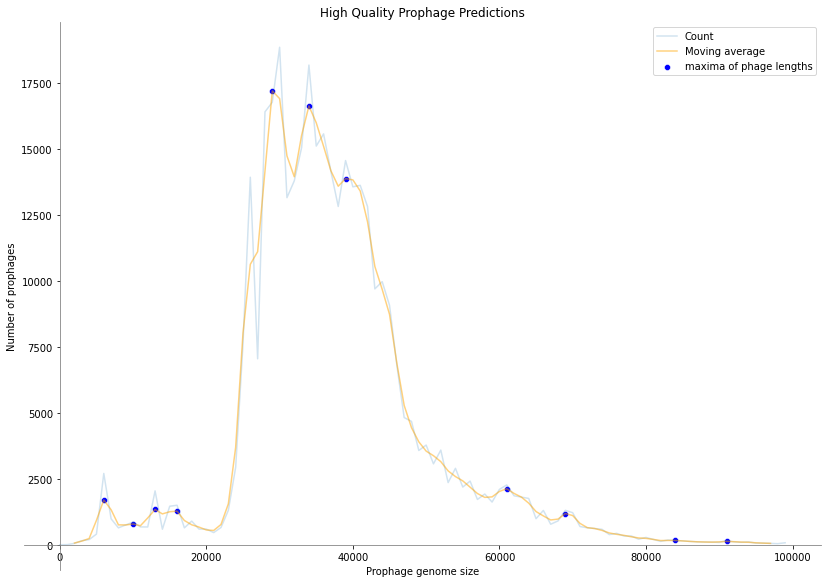

In [14]:
maxGenome = 100000


numBins=100
windowLength=5

count, division = np.histogram(df[df['contig_length']  < maxGenome]['contig_length'], bins=numBins)

np.max(division)        # Get histogram bin width
histogramBinSize = np.max(division)/numBins

hf = pd.DataFrame(count, columns=['Count'])
hf.index *= histogramBinSize

                        # Moving average
hf['ma'] = hf['Count'].rolling(windowLength, win_type='hanning', center=True).mean()

                        # Find local peaks
hf['min'] = hf.ma[(hf.ma.shift(1) > hf.ma) & (hf.ma.shift(-1) > hf.ma)]
hf['max'] = hf.ma[(hf.ma.shift(1) < hf.ma) & (hf.ma.shift(-1) < hf.ma)]

hf['min3'] = hf.ma[
    (hf.ma.shift(1) > hf.ma) &
    (hf.ma.shift(2) > hf.ma) &
    (hf.ma.shift(3) > hf.ma) &
    (hf.ma.shift(-3) > hf.ma) &
    (hf.ma.shift(-2) > hf.ma) &
    (hf.ma.shift(-1) > hf.ma)
    ]
hf['max3'] = hf.ma[
    (hf.ma.shift(1) < hf.ma) & 
    (hf.ma.shift(2) < hf.ma) & 
    (hf.ma.shift(3) < hf.ma) & 
    (hf.ma.shift(-3) < hf.ma) & 
    (hf.ma.shift(-2) < hf.ma) & 
    (hf.ma.shift(-1) < hf.ma)
    ]

hf['max4'] = hf.ma[(hf.ma > (hf['ma'].rolling(20, center=True).mean() + (1 * hf['ma'].rolling(20, center=True).std())))]

fig, ax = plt.subplots(1,1, figsize=(11.7,8.27))
sns.lineplot(x=hf.index, y='Count', data=hf, ax=ax, alpha=0.2, label='Count')
sns.lineplot(x=hf.index, y='ma', data=hf, ax=ax, color='orange', alpha=0.5, label="Moving average")
#sns.scatterplot(x=hf.index, y='ma', data=hf, ax=ax)
#sns.scatterplot(x=hf.index, y='min', color='r', data=hf, ax=ax, alpha=0.4, label='minima of phage lengths')
sns.scatterplot(x=hf.index, y='max', color='b', data=hf, ax=ax, label='maxima of phage lengths')
sns.color_palette("colorblind")
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')


ax.set_xlabel('Prophage genome size')
ax.set_ylabel('Number of prophages')
ax.set_title("High Quality Prophage Predictions")
plt.tight_layout()

fig.savefig('images/phage_lengths.png')
fig.savefig('images/phage_lengths.svg')

In [5]:
print("These are the predicted maxima of phage genome lengths:")
for mx in hf[hf['max'].notnull()].index:
    print(f" - {int(mx):>7,} bp",)
print()

These are the predicted maxima of phage genome lengths:
 -   5,981 bp
 -   9,720 bp
 -  12,711 bp
 -  14,954 bp
 -  19,441 bp
 -  24,675 bp
 -  28,414 bp
 -  33,648 bp
 -  38,882 bp
 -  56,828 bp
 -  59,819 bp
 -  64,305 bp
 -  67,296 bp
 -  71,783 bp
 -  78,512 bp
 -  81,503 bp
 -  88,981 bp
 -  96,458 bp
 -  98,701 bp
 - 100,944 bp
 - 105,431 bp
 - 114,404 bp
 - 117,395 bp
 - 119,638 bp
 - 128,611 bp
 - 132,349 bp
 - 134,593 bp
 - 139,827 bp
 - 154,034 bp
 - 156,277 bp
 - 160,016 bp
 - 163,755 bp
 - 183,944 bp



# Categories

Let's add the category data, and see if there is any difference in the moving average/maxima predicted.

See `RAST Sources` for more details about this analysis

In [6]:
catdf = read_categories()

In [7]:
checkvcat = pd.merge(checkv, catdf, on='assembly_accession', how='inner')[['assembly_accession', 'contig_length', 'Category', 'Biome']]
checkvcat

,assembly_accession,contig_length,Category,Biome
0,GCA_000003645.1,40297,food,Terrestrial
1,GCA_000003925.1,67074,soil,Terrestrial
2,GCA_000003925.1,79454,soil,Terrestrial
3,GCA_000003925.1,52180,soil,Terrestrial
4,GCA_000003925.1,30904,soil,Terrestrial
...,...,...,...,...
200187,GCA_001989895.1,55083,animal,Host-Associated
200188,GCA_001989935.1,79708,animal,Host-Associated
200189,GCA_001989375.1,30597,marine deep,Aquatic
200190,GCA_001989375.1,19724,marine deep,Aquatic


In [8]:
def moving_averages(df, colname, numBins=250, windowLength=5):
    """
    calculate some moving averages
    :param df: the pandas data frame
    :param colname: the column name to calculate the moving average
    :param numBins: The number of bins in the histogram
    :param windowLength: the length of the window to use
    """
    count, division = np.histogram(df[colname], bins=numBins)

    np.max(division)        # Get histogram bin width
    histogramBinSize = np.max(division)/numBins

    hf = pd.DataFrame(count, columns=['Count'])
    hf.index *= histogramBinSize

                            # Moving average
    hf['ma'] = hf['Count'].rolling(windowLength, win_type='hanning', center=True).mean()

                            # Find local peaks
    hf['min'] = hf.ma[(hf.ma.shift(1) > hf.ma) & (hf.ma.shift(-1) > hf.ma)]
    hf['max'] = hf.ma[(hf.ma.shift(1) < hf.ma) & (hf.ma.shift(-1) < hf.ma)]
    return hf

In [9]:
checkvcat

,assembly_accession,contig_length,Category,Biome
0,GCA_000003645.1,40297,food,Terrestrial
1,GCA_000003925.1,67074,soil,Terrestrial
2,GCA_000003925.1,79454,soil,Terrestrial
3,GCA_000003925.1,52180,soil,Terrestrial
4,GCA_000003925.1,30904,soil,Terrestrial
...,...,...,...,...
200187,GCA_001989895.1,55083,animal,Host-Associated
200188,GCA_001989935.1,79708,animal,Host-Associated
200189,GCA_001989375.1,30597,marine deep,Aquatic
200190,GCA_001989375.1,19724,marine deep,Aquatic


In [10]:
checkvcat.groupby('Biome').size()

Biome
Aquatic             18161
Host-Associated    135838
Terrestrial         46193
dtype: int64

These are the predicted maxima of phage genome lengths for Terrestrial prophages:
 11,994 bp
 19,991 bp
 72,967 bp
 87,960 bp
 92,958 bp

These are the predicted maxima of phage genome lengths for Host-Associated prophages:
  5,987 bp
 12,973 bp
 21,955 bp
 77,842 bp
 83,830 bp
 90,816 bp

These are the predicted maxima of phage genome lengths for Aquatic prophages:
  5,987 bp
 10,976 bp
 15,966 bp
 19,957 bp
 56,879 bp
 66,858 bp
 71,848 bp
 84,820 bp
 89,810 bp
 93,801 bp



Text(0.5, 1.0, 'High Quality Prophage Predictions\nBy Biome')

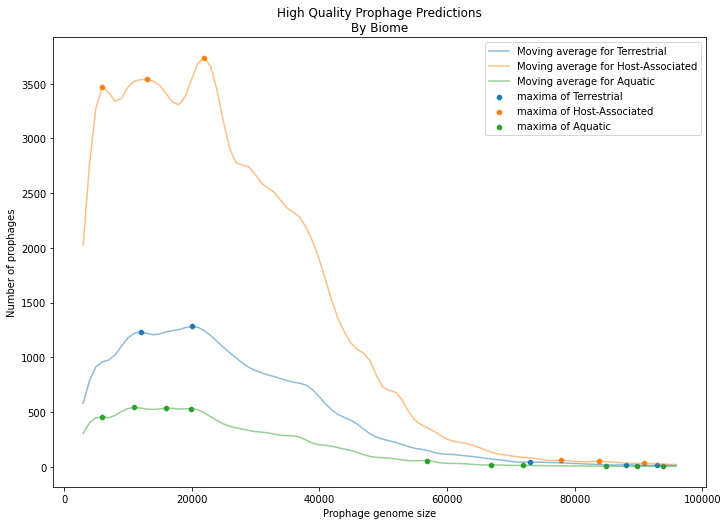

In [11]:
fig, ax = plt.subplots(1,1, figsize=(11.7,8.27))
"""
sns.lineplot(x=hf.index, y='Count', data=hf, ax=ax, alpha=0.2, label='Count')
sns.lineplot(x=hf.index, y='ma', data=hf, ax=ax, color='orange', alpha=0.5, label="Moving average")
#sns.scatterplot(x=hf.index, y='ma', data=hf, ax=ax)
sns.scatterplot(x=hf.index, y='min', color='r', data=hf, ax=ax, alpha=0.4, label='minima of phage lengths')
sns.scatterplot(x=hf.index, y='max', color='b', data=hf, ax=ax, label='maxima of phage lengths')
"""
sns.color_palette("colorblind")

for b in pd.unique(checkvcat['Biome']):
    madf = moving_averages(checkvcat[(checkvcat['Biome'] == b) & (checkvcat['contig_length'] < 100000)], 'contig_length', 100, 7)
    sns.lineplot(x=madf.index, y='ma', data=madf, ax=ax, alpha=0.5, label=f"Moving average for {b}")
    sns.scatterplot(x=madf.index, y='max', data=madf, ax=ax, label=f'maxima of {b}')
    print(f"These are the predicted maxima of phage genome lengths for {b} prophages:")
    for mx in madf[madf['max'].notnull()].index:
        print(f"{int(mx):>7,} bp",)
    print()


ax.set_xlabel('Prophage genome size')
ax.set_ylabel('Number of prophages')
ax.set_title("High Quality Prophage Predictions\nBy Biome")
